# Laboratorium 4

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

FIG_EPS = 0.1

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < FIG_EPS:
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_rects(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        


### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


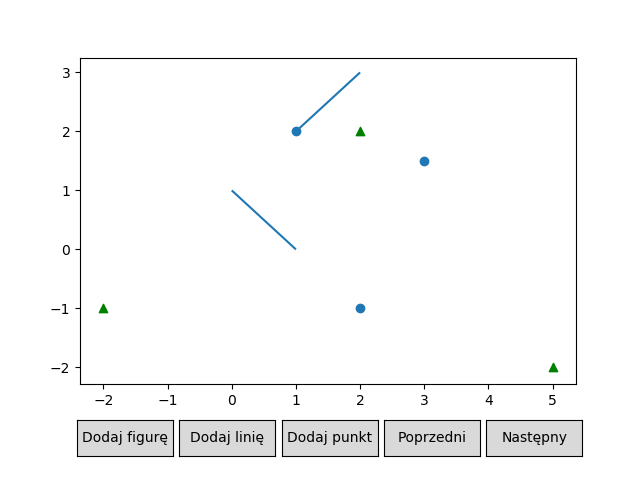

In [3]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


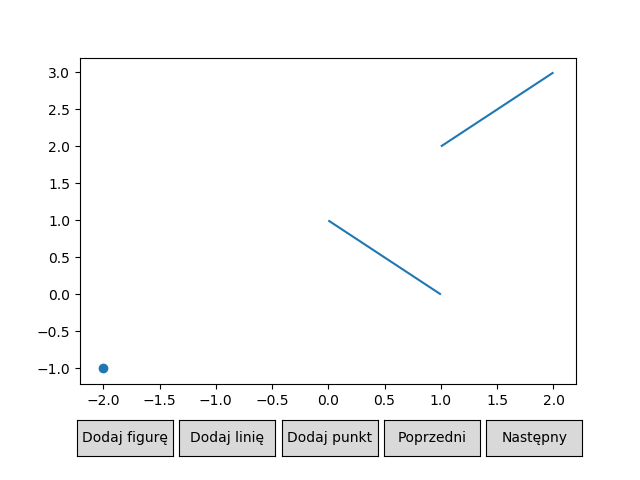

In [4]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


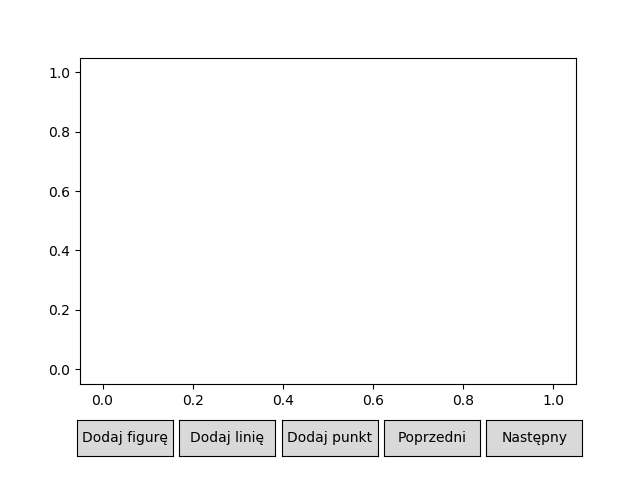

In [5]:
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


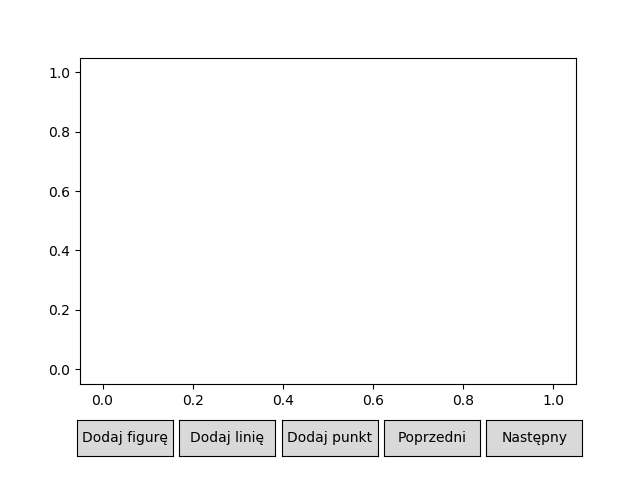

In [6]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

# Rozwiązanie 
# Rozwiązanie punktu 1 - interaktywne wprowadzanie wielokątów

In [7]:
%matplotlib notebook

# Poniżej definicja klasy Line, której używam w programie

In [7]:
from random import seed,random
              
class Line:
    def __init__(self,sx,sy,ex,ey):
        self.sx=sx
        self.sy=sy
        self.ex=ex
        self.ey=ey
   
    def __str__(self):
        return 'Line segment from ('+str(self.sx)+','+str(self.sy)+') to ('+str(self.ex)+','+str(self.ey)+')'

# Poniżej definicje funkcji zamieniających wielobok na linie oraz punkty, zawsze w kierunku przeciwnym do wskazówek zegara. Dodałem również funkcję get_added_rects() w programie do wizualizacji.

In [8]:
def det(a,b,c):
    return a[0]*b[1] + a[1]*c[0] + b[0]*c[1] - b[1]*c[0] - a[1]*b[0] - a[0]*c[1]

def orientation(a,b,c):
    c_det = det(a,b,c)
    if c_det>1e-7:
        return 1
    elif c_det<-1e-7:
        return -1
    else:
        return 0   

# check if polygon is clockwise
def clockwise(points):
    index=0
    min_y=float('inf')
    max_x=-float('inf')
    i=0
    for point in points:
        if point[1]<min_y or (point[1]==min_y and point[0]>max_x):
            min_y=point[1]
            max_x=point[0]
            index=i
        i += 1
    A=(points[index][0],points[index][1])
    B=(points[index-1][0],points[index-1][1])
    if B==A:
        B=(points[index-2][0],points[index-2][1])
    C=(points[index+1][0],points[index+1][1])
    if C==A:
        C=(points[index+2][0],points[index+2][1])
    o = orientation(A,B,C)
    if o==1:
        return True
    else:
        return False
    
    # change rect to list of points
def get_rect_to_vertexes(rect):
    points=[(round(rect[0].lines[0][0][0],8),round(rect[0].lines[0][0][1],8))]
    for lines in rect:
        for line in lines.lines:
            points.append((round(line[1][0],8),round(line[1][1],8)))
    if clockwise(points):
        points.reverse()
    return points

# change rect to list of Lines
def get_rect_to_lines(rect):
    result=[]
    tmp_points=get_rect_to_vertexes(rect)
    for i in range(0,len(tmp_points)-1):
        result.append(Line(tmp_points[i][0],tmp_points[i][1],tmp_points[i+1][0],tmp_points[i+1][1]))
    return result,tmp_points

def print_rect(lines,points):
    print("Lines:")
    for line in lines:
        print(line)
    print('\nPoints:')
    for point in points:
        print('('+str(point[0])+','+str(point[1])+')')

# Przykład wizualizacji

<IPython.core.display.Javascript object>


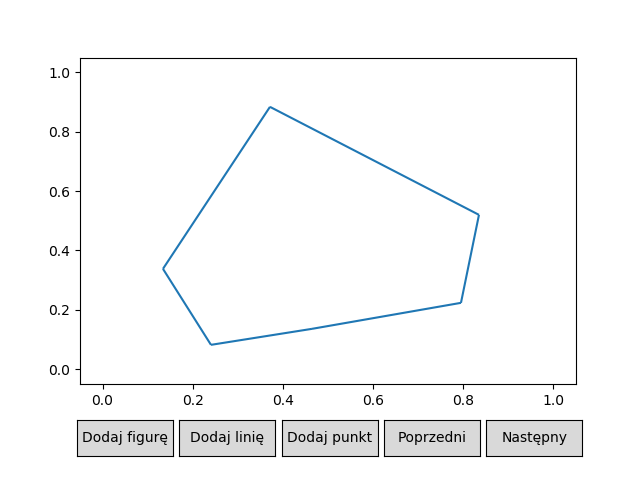

In [9]:
plot1 = Plot()
plot1.draw()

Lines:
Line segment from (0.13400328,0.33808785) to (0.24045489,0.0819604)
Line segment from (0.24045489,0.0819604) to (0.46444682,0.13588197)
Line segment from (0.46444682,0.13588197) to (0.79489037,0.22350452)
Line segment from (0.79489037,0.22350452) to (0.83480973,0.52007315)
Line segment from (0.83480973,0.52007315) to (0.37130166,0.88404373)
Line segment from (0.37130166,0.88404373) to (0.13400328,0.33808785)

Points:
(0.13400328,0.33808785)
(0.24045489,0.0819604)
(0.46444682,0.13588197)
(0.79489037,0.22350452)
(0.83480973,0.52007315)
(0.37130166,0.88404373)
(0.13400328,0.33808785)


<IPython.core.display.Javascript object>


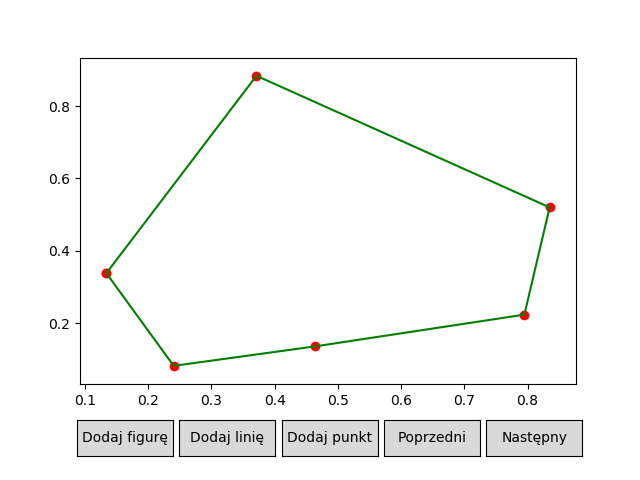

In [10]:
lines1,points1=get_rect_to_lines(plot1.get_added_rects())
print_rect(lines1,points1)
scene1=[Scene([PointsCollection(points1,color='red')],[LinesCollection([points1],color='green')])]
plotx=Plot(scene1)
plotx.draw()

# Poniżej funkcje umożliwiające zapis do pliku oraz odczyt z pliku

In [11]:
def generate_rect_from_file(file):                
    rect=[]
    with open(file, 'r') as file:
        rect = file.read()
    tmp_plot=Plot(json=rect)
    lines=tmp_plot.scenes[0].lines[0].lines
    points=[]
    for line in lines[0]:
        point = (line[0],line[1])
        points.append(point)
    return points,lines

def save_rect_to_file(file,plot):
    with open(file, 'w') as file:
        file.write(plot.toJson())

# Oraz przykład działania

<IPython.core.display.Javascript object>


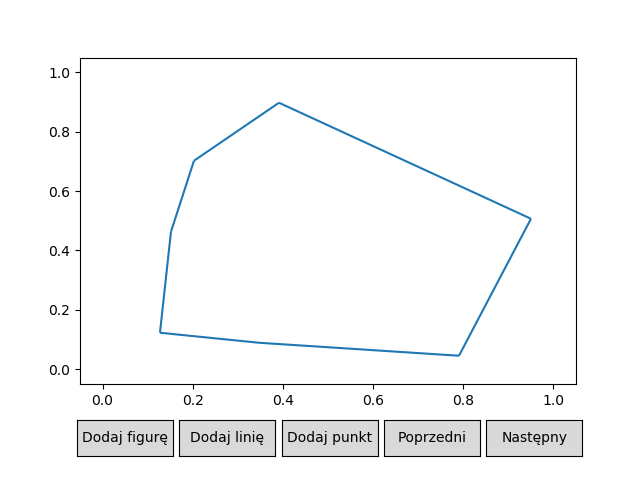

In [12]:
plotx=Plot()
plotx.draw()

<IPython.core.display.Javascript object>


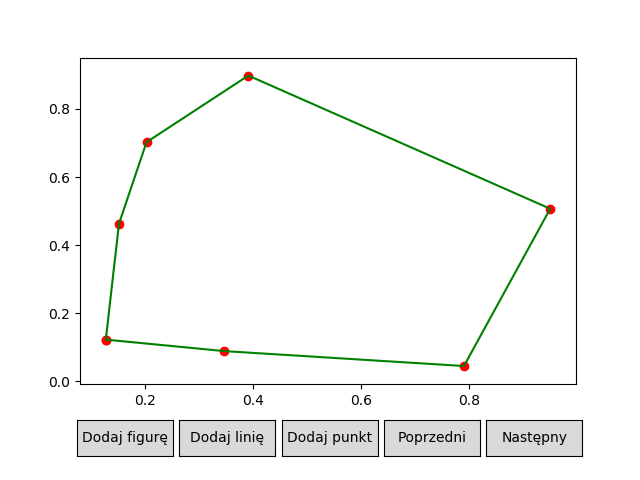

In [13]:
linesx,pointsx=get_rect_to_lines(plotx.get_added_rects())
scenex=[Scene([PointsCollection(pointsx,color='red')],[LinesCollection([pointsx],color='green')])]
ploty=Plot(scenex)
save_rect_to_file("test.txt",ploty)
points20,lines20=generate_rect_from_file("test.txt")
sceney=[Scene([PointsCollection(points20,color='red')],[LinesCollection([points20],color='green')])]
plotz=Plot(sceney)
plotz.draw()

# Rozwiązanie punktu 2 - sprawdzanie y-monotoniczności wielokąta. Opis programu znajduje się w pliku tekstowym "Punkt2.pdf"

In [14]:
def isPolygonMonotoneToY(points):                     # algorithm idea found on stackexchange
    min_y=min(points, key = lambda t: t[1])           # https://cs.stackexchange.com/questions/1577/how-do-i-test-if-a-polygon-is-monotone-with-respect-to-a-line
    max_y=max(points, key = lambda t: t[1])           # comment from "nbro"
    lower_index=points.index(min_y)
    upper_index=points.index(max_y)
    if lower_index<upper_index:
        lower=points[lower_index:upper_index+1]
        upper=points[upper_index:]+points[:lower_index+1]
    else:
        lower=points[lower_index:]+points[:upper_index+1]
        upper=points[upper_index:lower_index+1]
    isMonotone=True
    tmp=min_y[1]
    for point in lower:
        if point[1]<tmp:
            isMonotone=False
            break
        tmp=point[1]
    tmp=max_y[1]
    for point in upper:
        if point[1]>tmp:
            isMonotone=False
            break
        tmp=point[1]
    return isMonotone

# Przykład działania

<IPython.core.display.Javascript object>


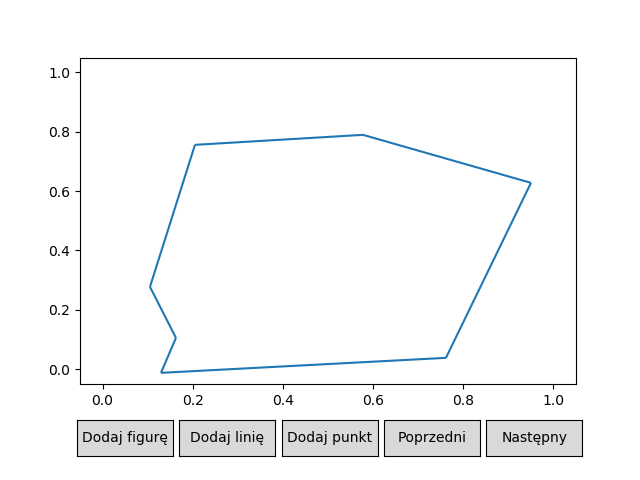

In [15]:
plot2 = Plot()
plot2.draw()

In [16]:
lines2,points2=get_rect_to_lines(plot2.get_added_rects())
print(isPolygonMonotoneToY(points2))

True


# Rozwiązanie punktu 3 - wyszukiwanie wierzchołków początkowych, końcowych, dzielących, łączących oraz prawidłowych

In [17]:
import math

def is_angle_convex(a, b, c):
    if det(a,b,c)>0:
        return True
    else:
        return False
    
def splitVertexes(points):
    start=[]                            # color = green
    end=[]                              # color = red
    divide=[]                           # color = cyan
    connect=[]                          # color = blue
    regular=[]                          # color = brown
    scene=[]
    scene=Plot(scene)
    for i in range(0,len(points)-1):
        neighbour1=points[i-1]
        if i==0:
            neighbour1=points[i-2]
        neighbour2=points[i+1]
        if(neighbour1[1]>points[i][1] and neighbour2[1]>points[i][1]):
            if is_angle_convex(neighbour1,points[i],neighbour2):
                end.append(points[i])
            else:
                connect.append(points[i])
        elif (neighbour1[1]<points[i][1] and neighbour2[1]<points[i][1]):
            if is_angle_convex(neighbour1,points[i],neighbour2):
                start.append(points[i])
            else:
                divide.append(points[i])
        else:
            regular.append(points[i])
    scene.add_scene(Scene([PointsCollection(start,color='green'),PointsCollection(end,color='red'),PointsCollection(divide,color='cyan'),
                    PointsCollection(connect,color='blue'),PointsCollection(regular,color='brown')],[LinesCollection([points])]))
    return scene

# Przykład działania

<IPython.core.display.Javascript object>


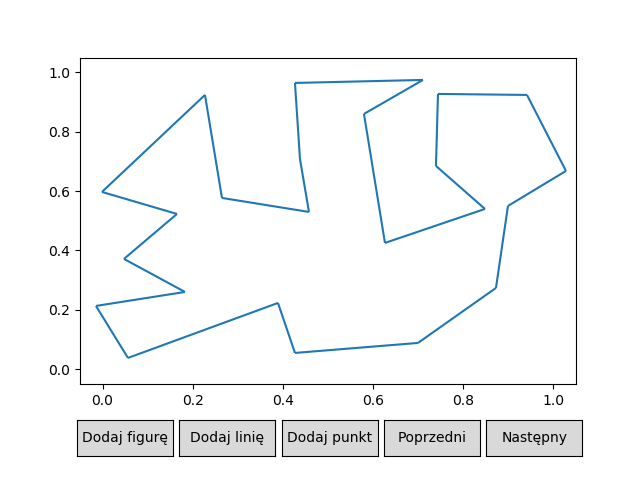

In [19]:
plot3=Plot()
plot3.draw()

<IPython.core.display.Javascript object>


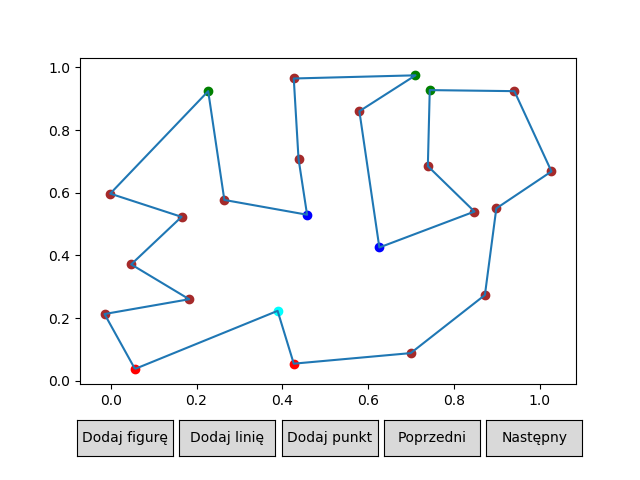

In [20]:
lines3,points3=get_rect_to_lines(plot3.get_added_rects())
plot4=splitVertexes(points3)
plot4.draw()

# Alternatywny sposób na sprawdzanie y-monotoniczności - sprawdzenie czy wielokąt nie ma wierzchołków dzielących i łączących

In [21]:
def isPolygonMonotoneToY2(points):
    start=[]                            
    end=[]                              
    divide=[]                           
    connect=[]                          
    regular=[]                         
    scene=[]
    scene=Plot(scene)
    for i in range(0,len(points)-1):
        neighbour1=points[i-1]
        if i==0:
            neighbour1=points[i-2]
        neighbour2=points[i+1]
        if(neighbour1[1]>points[i][1] and neighbour2[1]>points[i][1]):
            if is_angle_convex(neighbour1,points[i],neighbour2):
                end.append(points[i])
            else:
                connect.append(points[i])
        elif (neighbour1[1]<points[i][1] and neighbour2[1]<points[i][1]):
            if is_angle_convex(neighbour1,points[i],neighbour2):
                start.append(points[i])
            else:
                divide.append(points[i])
        else:
            regular.append(points[i])
    return len(divide)==0 and len(connect)==0

# Przykład działania

<IPython.core.display.Javascript object>


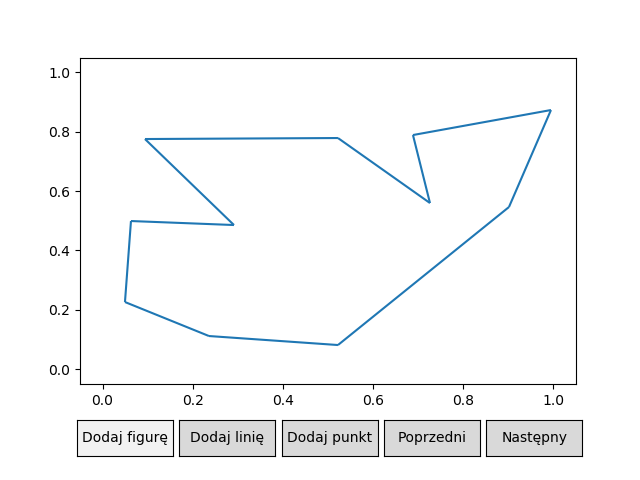

In [22]:
plot5 = Plot()
plot5.draw()

False


<IPython.core.display.Javascript object>


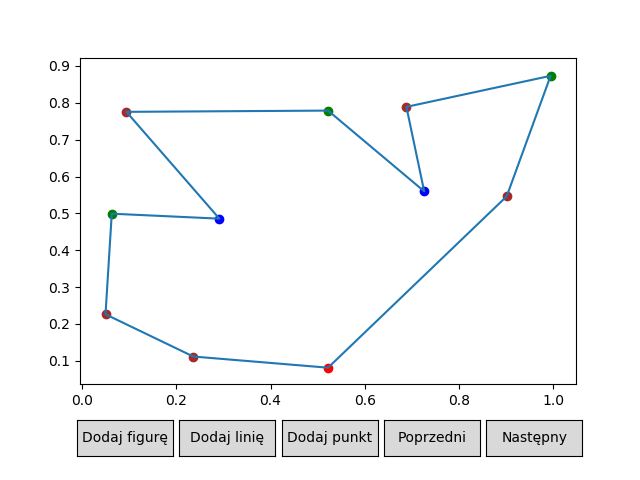

In [23]:
lines5,points5=get_rect_to_lines(plot5.get_added_rects())
print(isPolygonMonotoneToY2(points5))
plot6=splitVertexes(points5)
plot6.draw()

# Rozwiązanie punktu 4 - triangulacja wielokąta monotonicznego

# Klasa TriangulationPoint, której używam w programie

In [24]:
class TriangulationPoint:
    def __init__(self,x,y,type,index):
        self.x=x
        self.y=y
        self.type=type                     # type = -1 -> left, type = 1 -> right
        self.index=index
        
    def __eq__(self,other):
        return isinstance(other,self.__class__) and self.x==other.x and self.y==other.y
    
    def __lt__(self,other):
        return self.y<other.y or (self.y==other.y and self.x<other.x)
    
    def __str__(self):
        return '('+str(self.x)+','+str(self.y)+','+str(self.type)+ ') + index: ' + str(self.index)

# Funkcje pomocnicze

In [25]:
import copy

def delete_duplicates(points):
    result=[points[0]]
    for i in range(1,len(points)):
        if points[i] != result[-1]:
            result.append(points[i])
    return result

def det3(a,b,c):
    return a.x*b.y + a.y*c.x + b.x*c.y - b.y*c.x - a.y*b.x - a.x*c.y

def get_stack(t_stack):
    stack=[]
    for t in t_stack:
        stack.append((t.x,t.y))
    return stack

def add_step_1(steps,points,p,added_lines,stack):    
    current=copy.deepcopy(added_lines)
    steps.add_scene(Scene([PointsCollection(points),PointsCollection([(p.x,p.y)],color='red'),PointsCollection(stack,color='cyan')],[LinesCollection([points]),LinesCollection(current)]))

def add_step_2(steps,points,p,added_lines,top,stack):
    current=copy.deepcopy(added_lines)
    steps.add_scene(Scene([PointsCollection(points),PointsCollection(stack,color='cyan'),PointsCollection([(p.x,p.y)],color='red')],[LinesCollection([points]),LinesCollection(current),LinesCollection([[(top.x,top.y),(p.x,p.y)]],color='red')]))

def add_step_3(steps,points,p,added_lines,s1,s2,stack):
    current=copy.deepcopy(added_lines)
    steps.add_scene(Scene([PointsCollection(points),PointsCollection(stack,color='cyan'),PointsCollection([(p.x,p.y),(s1.x,s1.y),(s2.x,s2.y)],color='red')],[LinesCollection([points]),LinesCollection(current)]))
    
def insert_triangle(triangles,p1,p2,p3):
    tmp_list=[p1,p2,p3]
    tmp_list=sorted(tmp_list)
    triangles.append((tmp_list[0],tmp_list[1],tmp_list[2]))

# Algorytm triangulacji

In [26]:
def triangulation(points):                                      # red - current point, cyan - stack
    steps=[Scene([PointsCollection(points)],[LinesCollection([points])])]
    steps=Plot(steps)
    if not isPolygonMonotoneToY(points):
        print("The polygon is not monotone to Y, we will not do its triangulation")
        return steps,[]
    tmp=copy.deepcopy(points)
    points=points[:len(points)-1]
    min_y=min(points, key = lambda t: t[1])                                  # get 2 chains - starts here
    max_y=max(points, key = lambda t: t[1])                                  #     
    right_index=points.index(min_y)                                          #
    left_index=points.index(max_y)                                           #
    if right_index<left_index:                                               #           
        right=points[right_index:left_index+1]                               #
        left=points[left_index:]+points[:right_index+1]                      #
    else:                                                                    #
        right=points[right_index:]+points[:left_index+1]                     #
        left=points[left_index:right_index+1]                                # get 2 chains - ends here
    new_points=[]                                                            # prepare list of triangulation points
    i=left_index                                                             #
    for point in left:                                                       #
        new_points.append(TriangulationPoint(point[0],point[1],-1,i))        #
        i=(i+1)%len(points)                                                  # 
    i=right_index                                                            #
    for point in right:                                                      #
        new_points.append(TriangulationPoint(point[0],point[1],1,i))         #
        i=(i+1)%len(points)                                                  #
    new_points=sorted(new_points, reverse=True)                              #
    new_points=delete_duplicates(new_points)                                 # here the list is ready
    points=tmp                                                               #
    added_lines=[]                                                           #
    triangles=[]                                                             # created triangles, tuples of its indexes
    stack=[new_points[0],new_points[1]]                                      # put two first points on stack
    for p in new_points[2:]:                                                 # and here starts triangulation algorithm 
        stack_top=stack[-1]
        if p.type!=stack_top.type:
            while(len(stack)>0):
                g_stack=get_stack(stack)
                top=stack.pop()
                add_step_1(steps,points,p,added_lines,g_stack)
                add_step_2(steps,points,p,added_lines,top,g_stack)
                added_lines.append([(top.x,top.y),(p.x,p.y)])
                if len(stack)>0:
                    insert_triangle(triangles,p.index,top.index,stack[-1].index)
                add_step_1(steps,points,p,added_lines,g_stack)
            stack.append(stack_top)
            stack.append(p)
        else:
            while len(stack)> 1:
                g_stack=get_stack(stack)
                add_step_1(steps,points,p,added_lines,g_stack)
                add_step_3(steps,points,p,added_lines,stack[-1],stack[-2],g_stack)
                if not ((p.type==-1 and det3(p,stack[-1],stack[-2])<0) or (p.type==1 and det3(p,stack[-1],stack[-2])>0)):
                    break
                added_lines.append([(stack[-2].x,stack[-2].y),(p.x,p.y)])
                insert_triangle(triangles,p.index,stack[-1].index,stack[-2].index)
                add_step_1(steps,points,p,added_lines,g_stack)
                stack.pop()
            stack.append(p)
    steps.add_scene(Scene([PointsCollection(points),PointsCollection([points[0]],color='cyan')],[LinesCollection([points]),LinesCollection(added_lines)]))
    return steps,triangles

# Rozwiązanie punktu 5 znajduje się w pliku "Punkt5.pdf"

# Rozwiązanie punktu 6 - testowanie algorytmu na różnych zestawach danych # Opis wyboru znajduje się w pliku "Punkt6.pdf. W celu sprawdzenia poprawności znajdywanych trójkątów wierzchołek 0 został pokolorowany na inny kolor (cyan).

# Test 1 - prosta figura

<IPython.core.display.Javascript object>


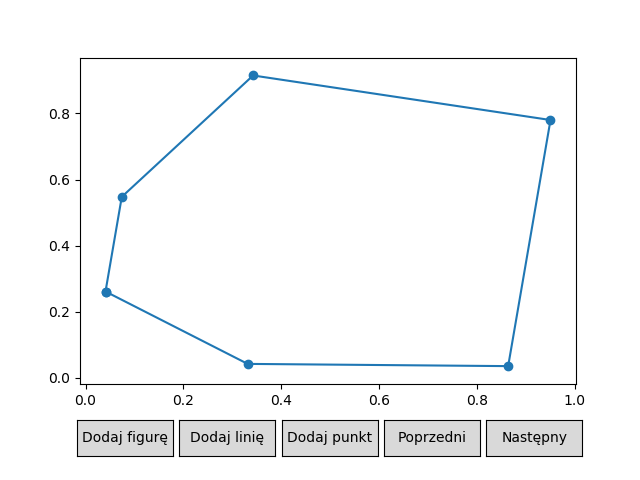

In [27]:
points7,lines7=generate_rect_from_file("Test1.txt")
scene7=[Scene([PointsCollection(points7)],[LinesCollection([points7])])]
plot7=Plot(scene7)
plot7.draw()

Triangles: [(3, 4, 5), (0, 3, 5), (0, 1, 3), (1, 2, 3)]


<IPython.core.display.Javascript object>


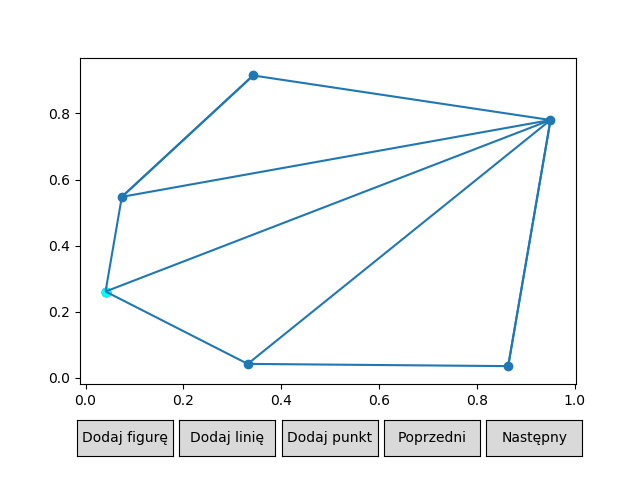

In [28]:
steps,triangles=triangulation(points7)
print("Triangles: " + str(triangles))
steps.draw()

# Test 2 - Figura, która nie jest y-monotoniczna

<IPython.core.display.Javascript object>


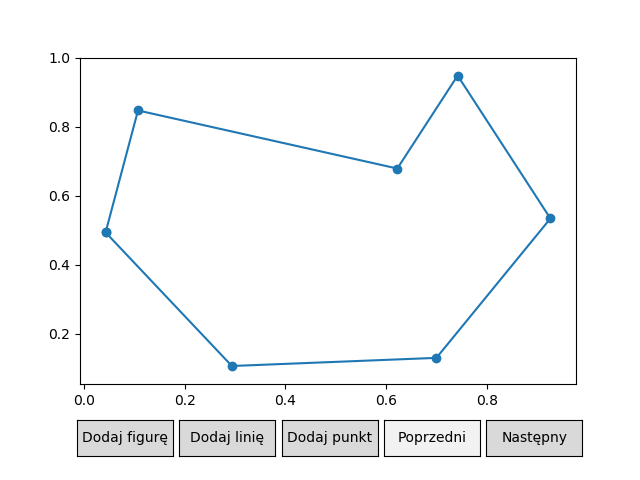

In [29]:
points8,lines8=generate_rect_from_file("Test2.txt")
scene8=[Scene([PointsCollection(points8)],[LinesCollection([points8])])]
plot8=Plot(scene8)
plot8.draw()

The polygon is not monotone to Y, we will not do its triangulation
Triangles: []


<IPython.core.display.Javascript object>


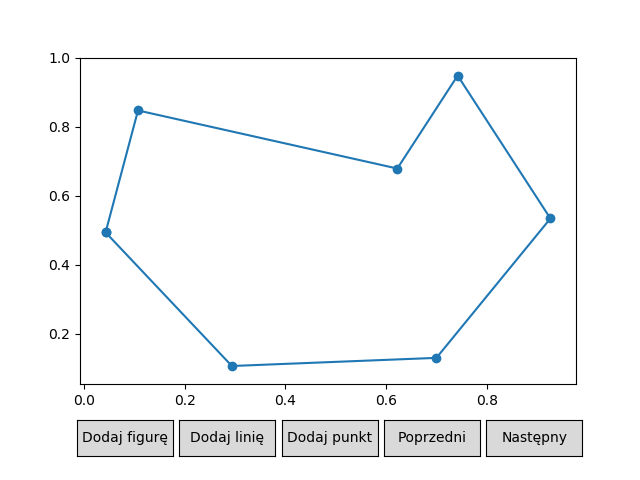

In [30]:
steps,triangles=triangulation(points8)
print("Triangles: " + str(triangles))
steps.draw()

# Test 3 - figura o większości wierzchołków na jednym z łańcuchów

<IPython.core.display.Javascript object>


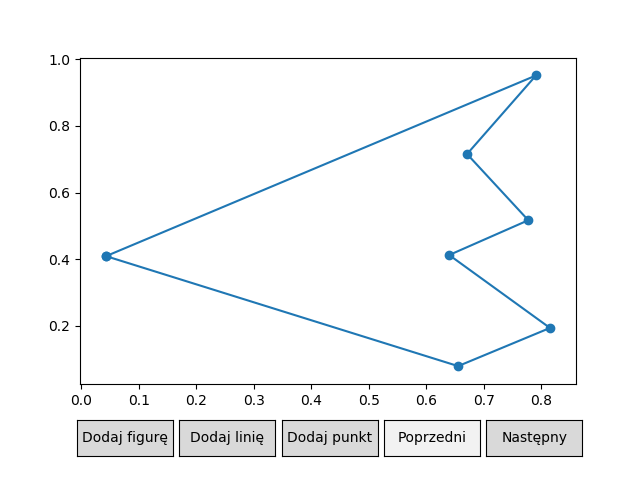

In [31]:
points9,lines9=generate_rect_from_file("Test3.txt")
scene9=[Scene([PointsCollection(points9)],[LinesCollection([points9])])]
plot9=Plot(scene9)
plot9.draw()

Triangles: [(3, 4, 5), (0, 3, 5), (0, 5, 6), (0, 2, 3), (0, 1, 2)]


<IPython.core.display.Javascript object>


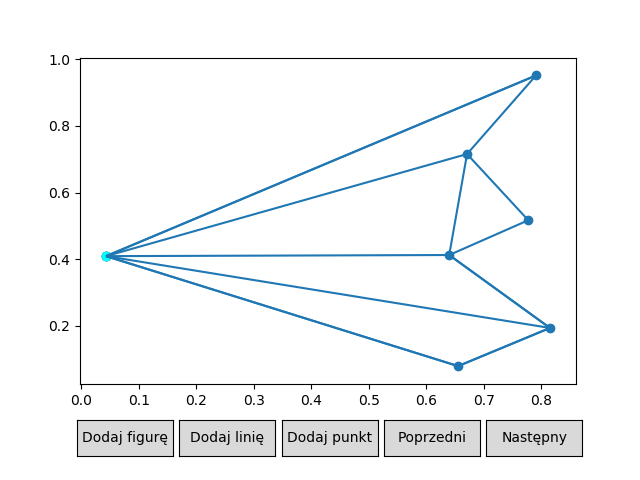

In [32]:
steps,triangles=triangulation(points9)
print("Triangles: " + str(triangles))
steps.draw()

# Test 4 - podobny do testu 3 ale więcej punktów

<IPython.core.display.Javascript object>


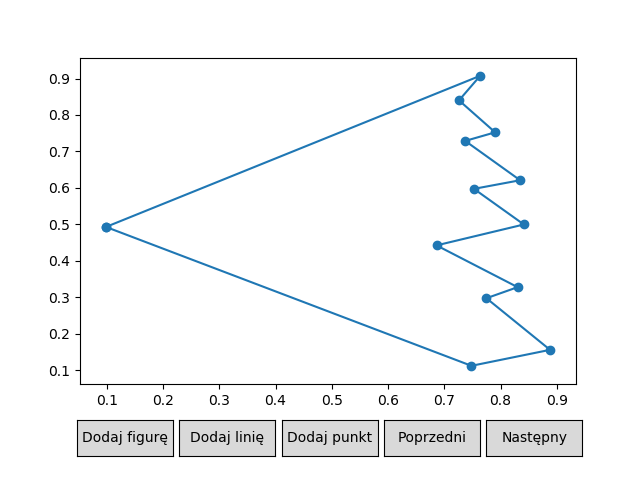

In [33]:
points10,lines10=generate_rect_from_file("Test4.txt")
scene10=[Scene([PointsCollection(points10)],[LinesCollection([points10])])]
plot10=Plot(scene10)
plot10.draw()

Triangles: [(9, 10, 11), (7, 8, 9), (0, 6, 7), (0, 7, 9), (0, 9, 11), (0, 11, 12), (0, 5, 6), (0, 4, 5), (0, 3, 4), (0, 2, 3), (0, 1, 2)]


<IPython.core.display.Javascript object>


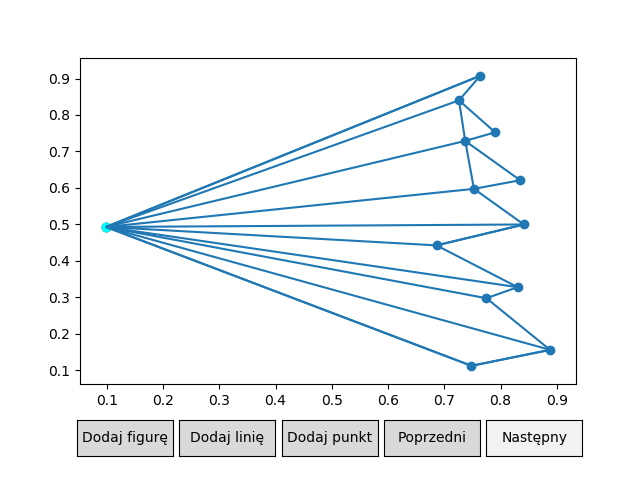

In [34]:
steps,triangles=triangulation(points10)
print("Triangles: " + str(triangles))
steps.draw()

# Test 5 - bardziej skomplikowana figura

<IPython.core.display.Javascript object>


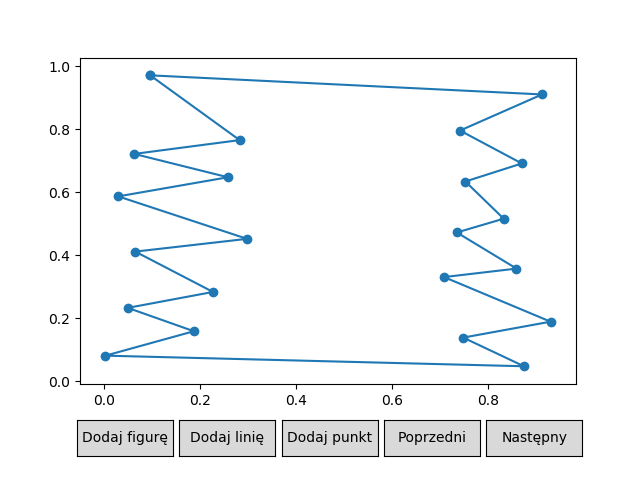

In [35]:
points11,lines11=generate_rect_from_file("Test5.txt")
scene11=[Scene([PointsCollection(points11)],[LinesCollection([points11])])]
plot11=Plot(scene11)
plot11.draw()

Triangles: [(0, 20, 21), (0, 1, 20), (1, 2, 20), (2, 19, 20), (2, 3, 19), (3, 18, 19), (3, 4, 18), (4, 17, 18), (4, 16, 17), (4, 5, 16), (5, 6, 16), (6, 15, 16), (6, 14, 15), (6, 7, 14), (7, 8, 14), (8, 13, 14), (8, 9, 13), (9, 12, 13), (9, 10, 12), (10, 11, 12)]


<IPython.core.display.Javascript object>


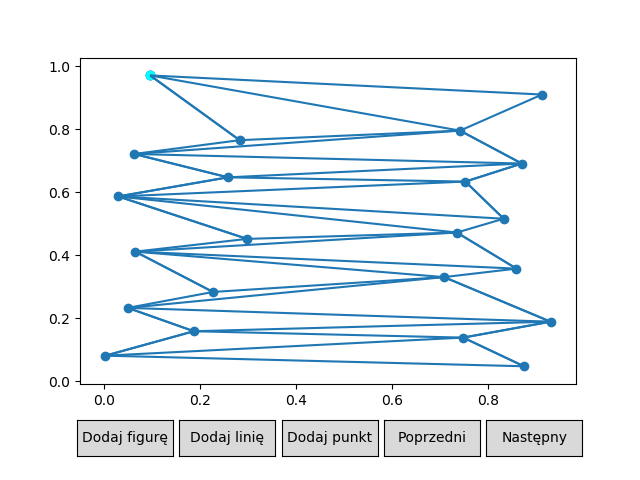

In [36]:
steps,triangles=triangulation(points11)
print("Triangles: " + str(triangles))
steps.draw()